# Классификация изображений

##### Автор: Виктор Китов ([DeepMachineLearning.ru](https://deepmachinelearning.ru))

##### Лицензия: BSD-3-Clause

В этом ноутбуке изучим способы классификации изображений классическим машинным обучением (без нейросетей).

Будем классифицировать детесет `Intel Image Classification`. 

Данный датасет был изначально представлен компанией **Intel** для соревнований по распознаванию образов. Он содержит фотографии реальных сцен, распределенные по 6 категориям:
*   **Buildings** (Здания)
*   **Forest** (Лес)
*   **Glacier** (Ледник)
*   **Mountain** (Горы)
*   **Sea** (Море)
*   **Street** (Улица)

Изображения имеют стандартный размер **150x150** пикселей и представлены в цветовом пространстве **RGB**. Этот датасет является отличным полигоном для тестирования алгоритмов, так как классы (например, «Горы» и «Ледники») имеют схожую цветовую гамму и текстуру, что требует от моделей выявления нетривиальных закономерностей.

### Что мы сделаем в этом исследовании:

1.  **Подготовка данных:** 
    Создадим эффективный инструмент для загрузки изображений с диска, который будет выполнять «умный» ресайз, центрирование и нормализацию интенсивности пикселей в диапазоне `[-1, 1]`.
    
2.  **Baseline-модель (Сырые пиксели):**
    Попробуем обучить линейный классификатор (**SGDClassifier**) напрямую на значениях яркости пикселей. Это позволит нам понять нижнюю границу точности и оценить сложность задачи.

3.  **Извлечение цветовых признаков:**
    Проверим гипотезу: достаточно ли модели знать только средний цвет и разброс каналов (R, G, B) для классификации? Сократим размерность признаков с 67 500 до 6 чисел и сравним результат.

4.  **Bag of Visual Words (BoVW) — «Мешок визуальных слов»:**
    Реализуем более продвинутый подход:
    *   Нарежем изображения на тысячи мелких патчей.
    *   С помощью кластеризации (**MiniBatchKMeans**) создадим «визуальный словарь» типичных текстур.
    *   Представим каждое изображение как гистограмму частот этих визуальных слов.
    
5.  **Эксперименты и оптимизация:**
    *   Проведем поиск оптимальных гиперпараметров (регуляризация `alpha`).
    *   Исследуем влияние размера патча на итоговую точность модели.
    
6.  **Глубокий анализ ошибок:**
    С помощью матриц ошибок (Confusion Matrix) проанализируем, какие классы модель путает чаще всего и почему «классическим» алгоритмам трудно их разделить.

В конечном итоге мы выясним, какого максимума точности можно достичь, не прибегая к использованию глубоких нейросетей.

Его можно сказать [здесь](https://github.com/luangtatipsy/intel-image-classification/tree/master) и в коде настроить `train_path` и `test_path`, чтобы они указывали на обучающую и тестовую выборки внутри папки датасета.

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Загрузим данные

In [2]:
class ImageDataset:
    def __init__(self, root_dir, img_size=(150, 150), transform=None):
        self.root_dir = root_dir
        self.img_size = img_size
        self.transform = transform
        
        self.X = []
        self.y = []
        
        # Определяем классы
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Собираем пути
        temp_samples = []
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    temp_samples.append((os.path.join(cls_path, img_name), cls_name))

        passed_img_count = 0
        for img_path, cls_name in tqdm(temp_samples, desc=f"Loading {os.path.basename(root_dir)}"):
                with Image.open(img_path) as img:
                    # 1. Проверка на квадратность
                    w, h = img.size
                    if w != h:
                        passed_img_count+=1
                        continue
                    
                    # 2. Приведение к RGB для унификации размерности массива (3 канала)
                    img = img.convert('RGB')
                    
                    # 3. Resize
                    img = img.resize(self.img_size, Image.Resampling.LANCZOS)
                    
                    # 4. В Numpy float32 и масштабирование в [-1, 1]
                    img_array = np.array(img).astype(np.float32)
                    img_array = (img_array / 127.5) - 1.0
                    
                    # 5. Transform
                    if self.transform:
                        img_array = self.transform(img_array)
                    
                    self.X.append(img_array)
                    self.y.append(self.class_to_idx[cls_name])

        self.X = np.array(self.X)
        self.y = np.array(self.y)

        print(f"Загрузилось {len(self.X)} изображений размера {self.img_size[0]}x{self.img_size[1]} из {os.path.basename(root_dir)}")
        print(f"Пропущено {passed_img_count} изображений, которые не являлись квадратными")

    def __len__(self):
        return len(self.X)

    def get_data(self, flatten=True):
        if flatten:
            return self.X.reshape(len(self.X), -1), self.y
        return self.X, self.y

In [3]:
# 1. Инициализация путей
train_path = "/data/DATASETS/IMAGE/CLASSIFICATION/Intel-Image-Classification/seg_train"
test_path = "/data/DATASETS/IMAGE/CLASSIFICATION/Intel-Image-Classification/seg_test"

SIZE = 75  # изображения будут 75x75 (Уменьшить, если не зватает памяти. Сами изображения 150x150)

# 2. Создание объектов Dataset (загрузка в память, ассерт на квадратность и шкалирование в [-1, 1])
# Мы не передаем transform, так как базовая нормализация уже внутри класса
train_set = ImageDataset(train_path, img_size=(SIZE, SIZE))
test_set = ImageDataset(test_path, img_size=(SIZE, SIZE))

Loading seg_train: 100%|████████████████| 14034/14034 [00:05<00:00, 2742.01it/s]


Загрузилось 13986 изображений размера 75x75 из seg_train
Пропущено 48 изображений, которые не являлись квадратными


Loading seg_test: 100%|███████████████████| 3000/3000 [00:01<00:00, 2871.06it/s]

Загрузилось 2993 изображений размера 75x75 из seg_test
Пропущено 7 изображений, которые не являлись квадратными


In [4]:
# 3. Получение данных в формате scikit-learn (X — плоский вектор, Y — метка)
X_train, Y_train = train_set.get_data(flatten=True)
X_test, Y_test = test_set.get_data(flatten=True)

# 4. Вывод информации о количестве объектов
print("\n" + "="*30)
print(f"Объектов в TRAIN: {X_train.shape[0]}")
print(f"Объектов в TEST:  {X_test.shape[0]}")
print("="*30)

# 5. Вывод размеров первых элементов
print(f"Размер первого элемента X_train: {X_train[0].shape}")
print(f"Значение первого элемента Y_train: {Y_train[0]} (индекс класса)")

# Дополнительная проверка диапазона значений
print(f"Диапазон значений X (min/max): {X_train.min()} / {X_train.max()}")


Объектов в TRAIN: 13986
Объектов в TEST:  2993
Размер первого элемента X_train: (16875,)
Значение первого элемента Y_train: 0 (индекс класса)
Диапазон значений X (min/max): -1.0 / 1.0


# Построим распределение по классам

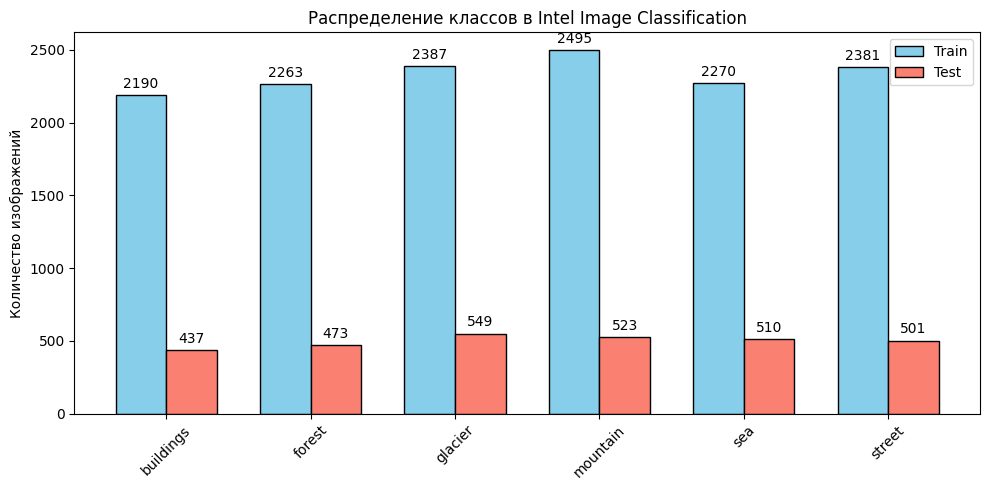

Статистика по классам:
Класс 0 (buildings ): Train = 2190, Test =  437
Класс 1 (forest    ): Train = 2263, Test =  473
Класс 2 (glacier   ): Train = 2387, Test =  549
Класс 3 (mountain  ): Train = 2495, Test =  523
Класс 4 (sea       ): Train = 2270, Test =  510
Класс 5 (street    ): Train = 2381, Test =  501


In [5]:
# 1. Получаем уникальные индексы и их количество
train_indices, train_counts = np.unique(Y_train, return_counts=True)
test_indices, test_counts = np.unique(Y_test, return_counts=True)

# 2. Названия классов для оси X
class_names = train_set.classes

# 3. Настройка графиков
x = np.arange(len(class_names))  # Расположение меток классов
width = 0.35  # Ширина столбцов

fig, ax = plt.subplots(figsize=(10, 5))

# Отрисовка столбцов
rects1 = ax.bar(x - width/2, train_counts, width, label='Train', color='skyblue', edgecolor='black')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test', color='salmon', edgecolor='black')

# Добавление текста, заголовков и меток
ax.set_ylabel('Количество изображений')
ax.set_title('Распределение классов в Intel Image Classification')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

# Функция для добавления подписей над столбцами
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Смещение на 3 пункта вверх
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Печать в консоль для точности
print("Статистика по классам:")
for i, name in enumerate(class_names):
    print(f"Класс {i} ({name:10}): Train = {train_counts[i]:4}, Test = {test_counts[i]:4}")

# Логистическая регрессия на исходных признаках
Будем её оценивать через `SGDClassifier` с `loss='log_loss'`, который хорошо работает для больших выборок, как у нас (загружает больше ядер процессора и считается быстрее).

*   **LogisticRegression (LBFGS):** Это «пакетный» (batch) метод. Он смотрит сразу на **все** изображения и вычисляет градиент по всему массиву
*   **SGDClassifier:** Обновляет веса после **каждого** изображения. 

In [6]:
# 1. Инициализируем базовую модель
sgd = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    max_iter=500, 
    tol=1e-3,
    random_state=42
)

# 2. Сетка alpha (от очень слабой до сильной регуляризации)
param_grid = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10]
}

print("Начинаю поиск оптимального alpha по сетке (CV=3)...")
grid_search = GridSearchCV(sgd, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)   # n_jobs=1,2 если OutOfMemory
grid_search.fit(X_train, Y_train)

# 3. Вывод лучшего результата
best_alpha = grid_search.best_params_['alpha']
print("\n" + "="*30)
print(f"ЛУЧШЕЕ ЗНАЧЕНИЕ ALPHA: {best_alpha}")
print(f"Точность на кросс-валидации: {grid_search.best_score_:.4f}")
print("="*30)

# Финальная модель с лучшим alpha
model = grid_search.best_estimator_

Начинаю поиск оптимального alpha по сетке (CV=3)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...........................................alpha=10; total time=   9.7s
[CV] END ...........................................alpha=10; total time=   9.9s
[CV] END ...........................................alpha=10; total time=  10.1s
[CV] END ............................................alpha=1; total time=  13.2s
[CV] END ............................................alpha=1; total time=  13.3s
[CV] END ............................................alpha=1; total time=  14.0s
[CV] END ..........................................alpha=0.1; total time=  30.7s
[CV] END ..........................................alpha=0.1; total time=  36.5s
[CV] END ..........................................alpha=0.1; total time=  38.7s

ЛУЧШЕЕ ЗНАЧЕНИЕ ALPHA: 0.1
Точность на кросс-валидации: 0.5348


In [7]:
def test_model(model, dataset, X):
    """
    Тестирование модели на датасете dataset и матрице признаков X
    """
    y_true = dataset.y
    class_names = dataset.classes
    
    # Предсказание на заранее подготовленных статистиках
    y_pred = model.predict(X)
    
    acc = accuracy_score(y_true, y_pred)
    print("\n" + "="*50)
    print(f"РЕЗУЛЬТАТЫ")
    print("="*50)
    print(f"Точность (Accuracy): {acc:.4f}")
    
    print("\nОтчет по классам:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Матрица ошибок')
    plt.ylabel('Реальные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


РЕЗУЛЬТАТЫ
Точность (Accuracy): 0.5185

Отчет по классам:
              precision    recall  f1-score   support

   buildings       0.39      0.33      0.36       437
      forest       0.76      0.70      0.73       473
     glacier       0.43      0.68      0.53       549
    mountain       0.56      0.59      0.58       523
         sea       0.38      0.22      0.28       510
      street       0.60      0.56      0.58       501

    accuracy                           0.52      2993
   macro avg       0.52      0.51      0.51      2993
weighted avg       0.52      0.52      0.51      2993



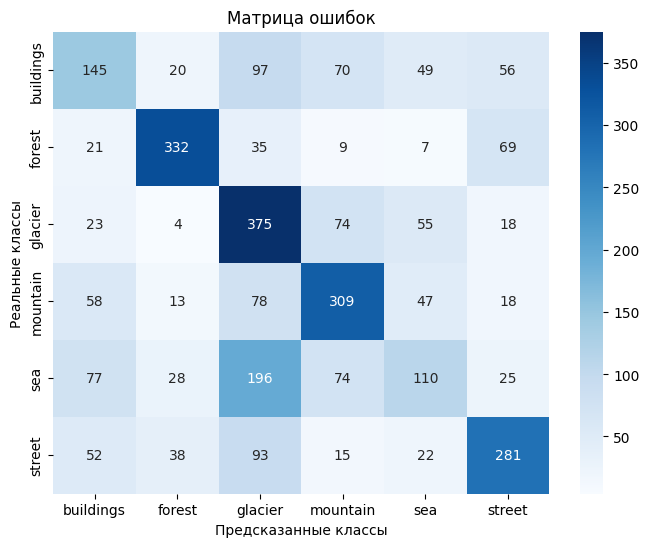

In [8]:
# Запускаем тест для лучшей модели
test_model(model, test_set, X_test)

# Случайный лес

In [27]:
from sklearn.ensemble import RandomForestClassifier

Запуск GridSearch для RandomForest (подбор max_features)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ........................................alpha=0.001; total time= 5.4min
[CV] END ...................................sgd__alpha=0.001; total time= 7.1min
[CV] END ....................................sgd__alpha=0.01; total time= 6.8min
[CV] END .........................................alpha=0.01; total time= 3.1min
[CV] END ...................................sgd__alpha=0.001; total time= 6.8min
[CV] END ........................................alpha=0.001; total time= 5.5min
[CV] END ...................................sgd__alpha=0.001; total time= 6.6min
[CV] END .........................................alpha=0.01; total time= 2.8min
[CV] END ..................................sgd__alpha=0.0001; total time= 5.7min
[CV] END ........................................alpha=0.001; total time= 5.8min
[CV] END ..................................sgd__alpha=0.0001; total tim

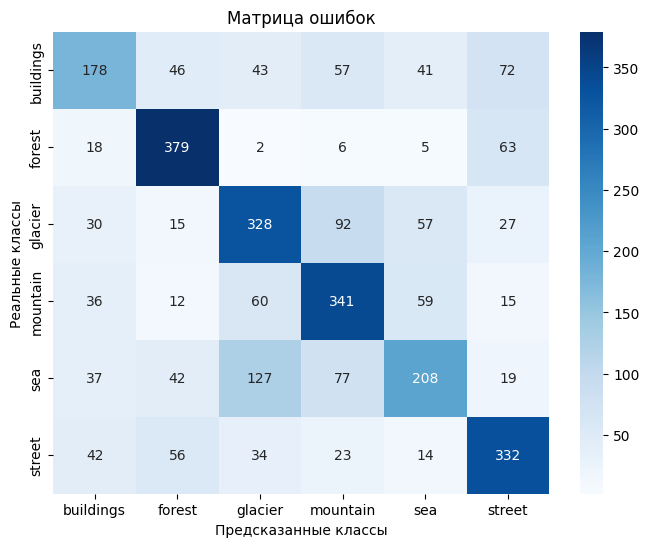

In [28]:
# 1. Инициализируем модель
# max_depth=15: ограничиваем глубину, чтобы избежать бесконечного роста деревьев.
rf = RandomForestClassifier(
    n_estimators=50, 
    random_state=42,
    min_samples_leaf=5,
    n_jobs=-1 # Используем все ядра
)

# 2. Сетка параметров
param_grid = {
    'max_features': [0.01, 0.05, 0.1]
}

print("Запуск GridSearch для RandomForest (подбор max_features)...")

# Используем %%time в начале ячейки, если вы в Jupyter
grid_search_rf = GridSearchCV(
    rf, 
    param_grid, 
    cv=3, 
    scoring='accuracy', 
    verbose=2,
    n_jobs=-1
)

grid_search_rf.fit(X_train, Y_train)

# 3. Результаты
print("\n" + "="*30)
print(f"ЛУЧШЕЕ ЗНАЧЕНИЕ MAX_FEATURES: {grid_search_rf.best_params_['max_features']}")
print(f"Точность на кросс-валидации: {grid_search_rf.best_score_:.4f}")
print("="*30)

# Финальная модель
model_rf = grid_search_rf.best_estimator_

# Тестируем через вашу функцию
test_model(model_rf, test_set, X_test)

# Создадим датасет статистик
Он будет включать только глобальные средние и стандартные отклонения по каждому цветовому каналу (6 признаков)

In [9]:
def extract_color_stats(X_images):
    """
    Принимает массив (N, H, W, 3) в диапазоне [-1, 1]
    Возвращает массив (N, 6): [mean_R, mean_G, mean_B, std_R, std_G, std_B]
    """
    # Среднее по осям высоты и ширины (остаются только каналы)
    means = np.mean(X_images, axis=(1, 2)) 
    # Стандартное отклонение по тем же осям
    stds = np.std(X_images, axis=(1, 2))
    
    # Склеиваем их горизонтально
    return np.hstack([means, stds])

# Получаем "сырые" (не плоские) изображения из наших датасетов
X_train_raw, Y_train = train_set.get_data(flatten=False)
X_test_raw, Y_test = test_set.get_data(flatten=False)

# Создаем новые наборы признаков
X_train_stat = extract_color_stats(X_train_raw)
X_test_stat = extract_color_stats(X_test_raw)

print(f"Новая размерность TRAIN: {X_train_stat.shape}") # Должно быть (N, 6)
print(f"Пример признаков первого фото: \n{X_train_stat[0]}")

Новая размерность TRAIN: (13986, 6)
Пример признаков первого фото: 
[0.30821377 0.29699248 0.28812248 0.6230482  0.63953304 0.6498867 ]


In [10]:


sgd_stat = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    max_iter=2000,
    tol=1e-3,
    random_state=42
)

# Сетка alpha
param_grid = {'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

grid_search_stat = GridSearchCV(sgd_stat, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_stat.fit(X_train_stat, Y_train)

best_alpha_stat = grid_search_stat.best_params_['alpha']
print(f"Лучшее alpha для статистик: {best_alpha_stat}")
print(f"Точность на кросс-валидации (статистики): {grid_search_stat.best_score_:.4f}")

model_stat = grid_search_stat.best_estimator_

Лучшее alpha для статистик: 0.0001
Точность на кросс-валидации (статистики): 0.4600



РЕЗУЛЬТАТЫ
Точность (Accuracy): 0.4557

Отчет по классам:
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.71      0.77      0.74       473
     glacier       0.46      0.73      0.56       549
    mountain       0.53      0.26      0.35       523
         sea       0.30      0.32      0.31       510
      street       0.37      0.59      0.45       501

    accuracy                           0.46      2993
   macro avg       0.39      0.45      0.40      2993
weighted avg       0.40      0.46      0.41      2993



/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

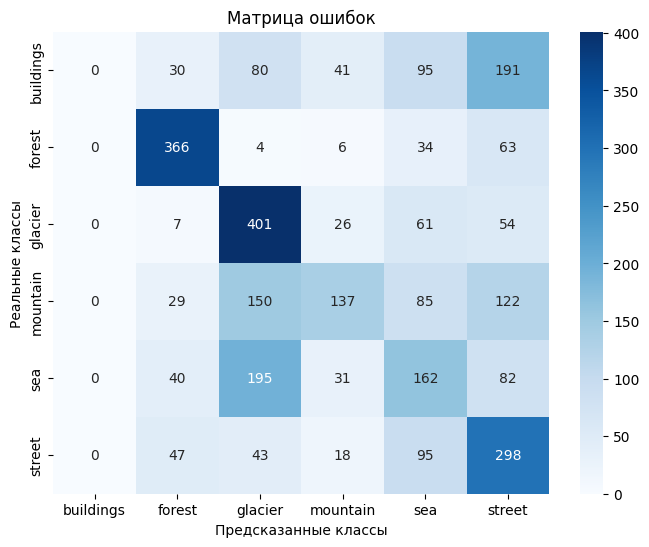

In [11]:
# Запускаем тест для лучшей модели
test_model(model_stat, test_set, X_test_stat)

# Объединим пиксельные и глобальные признаки

In [12]:
# Объединяем плоские пиксели и статистики
X_train_combined = np.hstack([X_train, X_train_stat])
X_test_combined = np.hstack([X_test, X_test_stat])

In [13]:
# Создаем Pipeline: Масштабирование -> SGD
pipe_combined = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(
        loss='log_loss',
        penalty='l2',
        max_iter=500,
        tol=1e-3,
        random_state=42
    ))
])

# Сетка alpha. Для такого количества признаков обычно подходят небольшие значения
param_grid = {
    'sgd__alpha': [1e-4, 1e-3, 1e-2, 0.1]
}

print("Запуск поиска по сетке для объединенных признаков...")
grid_combined = GridSearchCV(pipe_combined, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1) # n_jobs=1,2 если OutOfMemory
grid_combined.fit(X_train_combined, Y_train)

print(f"Лучшее alpha: {grid_combined.best_params_['sgd__alpha']}")
print(f"Лучшая точность на CV: {grid_combined.best_score_:.4f}")

model_combined = grid_combined.best_estimator_

Запуск поиска по сетке для объединенных признаков...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
 

[CV] END .....................................sgd__alpha=0.1; total time= 2.0min
[CV] END .....................................sgd__alpha=0.1; total time= 2.1min


/home/apogentus/Anaconda/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .....................................sgd__alpha=0.1; total time= 2.2min
Лучшее alpha: 0.1
Лучшая точность на CV: 0.5427



РЕЗУЛЬТАТЫ
Точность (Accuracy): 0.5316

Отчет по классам:
              precision    recall  f1-score   support

   buildings       0.37      0.29      0.32       437
      forest       0.70      0.77      0.73       473
     glacier       0.51      0.62      0.56       549
    mountain       0.56      0.59      0.57       523
         sea       0.38      0.29      0.33       510
      street       0.58      0.60      0.59       501

    accuracy                           0.53      2993
   macro avg       0.52      0.53      0.52      2993
weighted avg       0.52      0.53      0.52      2993



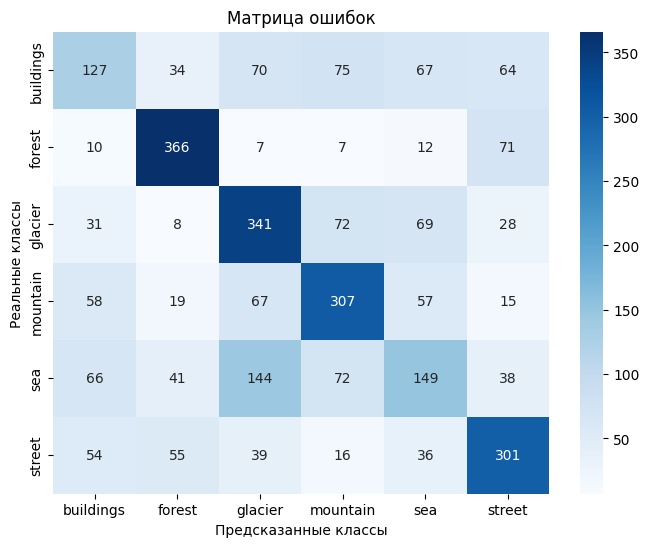

In [14]:
# Запускаем тест для лучшей модели
test_model(model_combined, test_set, X_test_combined)

# Кодировщик Bag-of-Visual-Words

Воспользуемся подходом **Bag of Visual Words** (мешок визуальных слов). Мы заставим модель искать не просто пиксели, а повторяющиеся текстуры (визуальные «слова»).

Для кластеризации тысяч патчей мы будем использовать `MiniBatchKMeans` — он работает гораздо быстрее обычного KMeans и поддерживает частичное обучение (`partial_fit`), что как раз подходит для итеративной настройки по эпохам.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d
from tqdm import tqdm

class VisualWordsEncoder:
    def __init__(self, dataset, K=100, patch_size=(8, 8), max_patches=50, epochs=1, batch_size=None):
        self.K = K
        self.patch_size = patch_size
        self.max_patches = max_patches
        
        # Если batch_size не задан, возьмем минимум в 2-3 раза больше чем K
        # Это обеспечит стабильную инициализацию MiniBatchKMeans
        if batch_size is None:
            self.batch_size = max(K * 2, 2000) 
        else:
            self.batch_size = batch_size

        self.kmeans = MiniBatchKMeans(
            n_clusters=K, 
            batch_size=self.batch_size, 
            random_state=42, 
            n_init=3
        )
        
        X_raw, _ = dataset.get_data(flatten=False)
        print(f"Обучение словаря (K={K}, патчи {patch_size[0]}x{patch_size[1]})...")
        
        for epoch in range(epochs):
            indices = np.random.permutation(len(X_raw))
            buffer = []  # Буфер для накопления патчей
            
            pbar = tqdm(indices, desc=f"Epoch {epoch+1}/{epochs}")
            for idx in pbar:
                img = X_raw[idx]
                patches = extract_patches_2d(img, self.patch_size, 
                                           max_patches=self.max_patches, 
                                           random_state=idx)
                
                # Добавляем выпрямленные патчи в буфер
                buffer.append(patches.reshape(len(patches), -1))
                
                # Считаем, сколько сейчас патчей в буфере
                current_buffer_size = len(buffer) * self.max_patches
                
                # Если накопили достаточно для одного MiniBatch — обучаем
                if current_buffer_size >= self.batch_size:
                    batch_data = np.vstack(buffer)
                    self.kmeans.partial_fit(batch_data)
                    buffer = [] # Очищаем буфер
            
            # Дообучаем на остатках в буфере после прохода по всем картинкам
            if len(buffer) > 0:
                batch_data = np.vstack(buffer)
                # Важно: даже здесь данных должно быть >= K для корректной работы
                if len(batch_data) >= self.K:
                    self.kmeans.partial_fit(batch_data)
        
        self.visual_words = self.kmeans.cluster_centers_

    
    def visualize(self, inds, size_scale=2.5):
        n = len(inds)
        rows = 3
        cols = int(np.ceil(n / rows))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * size_scale, rows * size_scale))
        axes = np.array(axes).flatten()
        for i in range(len(axes)):
            if i < n:
                ind = inds[i]
                word = self.visual_words[ind].reshape(self.patch_size[0], self.patch_size[1], 3)
                word_disp = np.clip((word + 1.0) / 2.0, 0, 1)
                axes[i].imshow(word_disp)
                axes[i].set_title(f"патч {ind}")
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

    def encode(self, image, max_patches=200):
        patches = extract_patches_2d(image, self.patch_size, 
                                   max_patches=max_patches, 
                                   random_state=42)
        patches_flat = patches.reshape(len(patches), -1)
        labels = self.kmeans.predict(patches_flat)
        counts = np.bincount(labels, minlength=self.K)
        return counts.astype(np.float32) / (counts.sum() + 1e-6)

In [16]:
def transform_to_bow(encoder, X_raw, max_patches_per_img=300):
    X_bow = []
    for img in tqdm(X_raw, desc="Кодирование"):
        features = encoder.encode(img, max_patches=max_patches_per_img)
        X_bow.append(features)
    return np.array(X_bow)

In [17]:
def plot_single_bow(bow_vec, img_idx, class_name):
    """
    Визуализирует распределение визуальных слов для одного вектора.
    """
    K = len(bow_vec)
    plt.figure(figsize=(14, 4))
    
    # Используем fill_between для лучшей читаемости при большом K
    plt.fill_between(range(K), bow_vec, color='royalblue', alpha=0.7)
    
    # Добавляем "иглы" для наглядности самых частых слов
    plt.vlines(range(K), 0, bow_vec, colors='navy', alpha=0.3, linewidth=0.5)

    plt.title(f"Распределение Visual Words | Изображение №{img_idx} ({class_name}) | K = {K}")
    plt.xlabel("Индекс визуального слова (ID кластера)")
    plt.ylabel("Частота (нормализованная)")
    
    # Считаем разреженность (сколько слов имеют ненулевой вес)
    active_count = np.sum(bow_vec > 0)
    plt.annotate(f"Активных слов: {active_count} из {K}\nРазреженность: {100*(1 - active_count/K):.1f}%", 
                 xy=(0.02, 0.8), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round", fc="white", alpha=0.8))

    plt.xlim(0, K)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

In [18]:
# Создаем энкодер BoVW
PATCH_SIZE = 12
encoder = VisualWordsEncoder(train_set, K=500, patch_size=(PATCH_SIZE, PATCH_SIZE), max_patches=30, epochs=1)

Обучение словаря (K=500, патчи 12x12)...


Epoch 1/1: 100%|█████████████████████████| 13986/13986 [00:14<00:00, 966.13it/s]


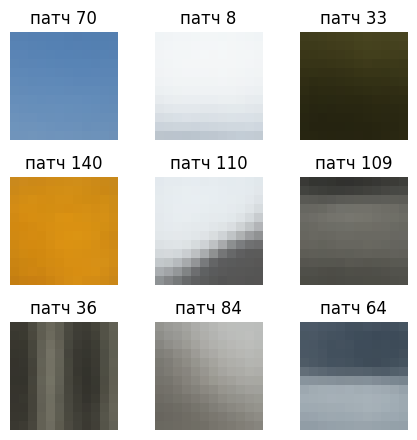

In [19]:
# Визуализируем 9 случайных визуальных слов
random_inds = np.random.choice(150, 9, replace=False)
encoder.visualize(random_inds, size_scale=1.5)

In [20]:
# Трансформируем данные
X_train_raw, Y_train = train_set.get_data(flatten=False)
X_test_raw, Y_test = test_set.get_data(flatten=False)

X_train_bow = transform_to_bow(encoder, X_train_raw, max_patches_per_img=250)
X_test_bow = transform_to_bow(encoder, X_test_raw, max_patches_per_img=250)

Кодирование:  59%|██████████████▏         | 8270/13986 [00:09<00:06, 820.17it/s]

[CV] END .........................................alpha=0.01; total time= 2.9min
[CV] END ..................................sgd__alpha=0.0001; total time= 5.2min


Кодирование: 100%|█████████████████████████| 2993/2993 [00:04<00:00, 697.26it/s]


In [21]:
X_train_bow.shape

(13986, 500)

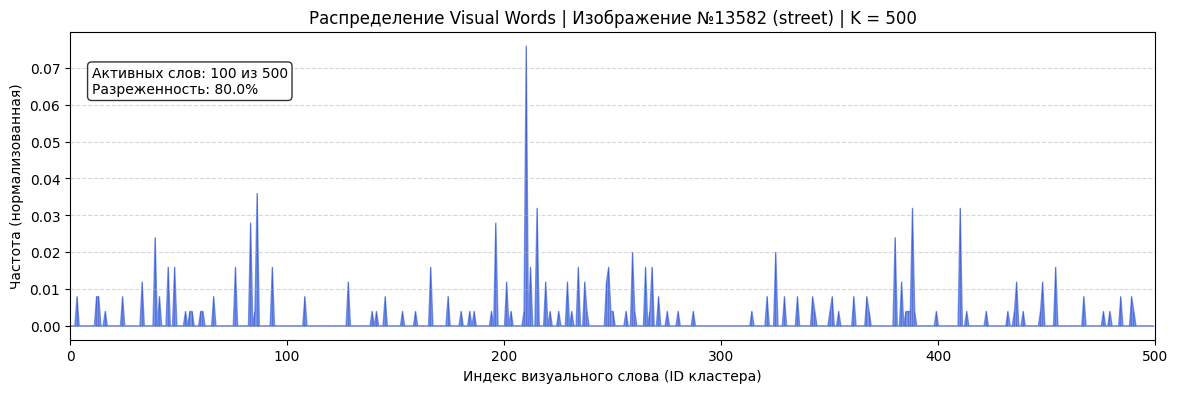

In [22]:
# 1. Выбираем случайный индекс из тренировочного набора
random_ind = np.random.randint(len(X_train_bow))

# 2. Получаем имя класса для заголовка
class_label = train_set.classes[Y_train[random_ind]]

# 3. Визуализируем
plot_single_bow(X_train_bow[random_ind], random_ind, class_label)

In [23]:
# Подбор регуляризации и настройка

param_grid = {'alpha': [1e-7, 1e-6, 1e-5]}
sgd = SGDClassifier(loss='log_loss', penalty='l2', max_iter=2000, random_state=42)

print("\nПодбор alpha для BoW-модели...")
grid_bow = GridSearchCV(sgd, param_grid, cv=5, n_jobs=-1)
grid_bow.fit(X_train_bow, Y_train)

print(f"Лучшее alpha: {grid_bow.best_params_['alpha']}")
print(f"Лучшая точность на CV: {grid_bow.best_score_:.4f}")


Подбор alpha для BoW-модели...
Лучшее alpha: 1e-06
Лучшая точность на CV: 0.6229



РЕЗУЛЬТАТЫ
Точность (Accuracy): 0.6325

Отчет по классам:
              precision    recall  f1-score   support

   buildings       0.53      0.66      0.59       437
      forest       0.83      0.77      0.80       473
     glacier       0.57      0.80      0.67       549
    mountain       0.61      0.65      0.63       523
         sea       0.73      0.40      0.52       510
      street       0.63      0.52      0.57       501

    accuracy                           0.63      2993
   macro avg       0.65      0.63      0.63      2993
weighted avg       0.65      0.63      0.63      2993



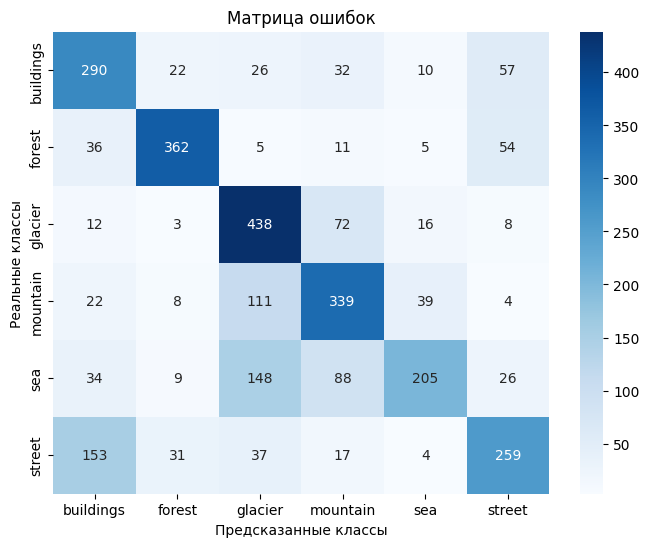

In [24]:
test_model(grid_bow.best_estimator_, test_set, X_test_bow)

# Зависимость точности от размера патча

In [25]:
def plot_experiment_results(args, accuracies, title, x_label="Параметр", y_label="Accuracy"):
    """
    Универсальный визуализатор результатов экспериментов.
    
    args: список значений аргумента (X)
    accuracies: список значений точности (Y)
    title: заголовок графика
    x_label: подпись оси X
    y_label: подпись оси Y
    """
    plt.figure(figsize=(10, 6), dpi=100)
    
    # Преобразуем в numpy для удобства поиска максимума
    args = np.array(args)
    accuracies = np.array(accuracies)
    
    # Строим основной график
    plt.plot(args, accuracies, marker='o', linestyle='-', color='#2c3e50', 
             linewidth=2.5, markersize=8, markerfacecolor='#e74c3c', label='Accuracy')

    # Подписываем каждое значение точности над точкой
    for i, acc in enumerate(accuracies):
        plt.annotate(f"{acc:.4f}", 
                     (args[i], accuracies[i]), 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     ha='center', 
                     fontsize=10, 
                     fontweight='bold',
                     color='#34495e')

    # Выделяем точку с максимальной точностью
    best_idx = np.argmax(accuracies)
    plt.scatter(args[best_idx], accuracies[best_idx], s=200, facecolors='none', 
                edgecolors='#27ae60', linewidths=2, label='Лучший результат')

    # Оформление осей и заголовка
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    # Настройка сетки
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Настройка делений оси X (чтобы были видны именно те значения, что мы передали)
    if isinstance(args[0], (int, float, np.number)):
        plt.xticks(args)
    
    # Динамические границы оси Y для красоты
    y_min, y_max = accuracies.min(), accuracies.max()
    padding = (y_max - y_min) * 0.2 if y_max != y_min else 0.05
    plt.ylim(y_min - padding, y_max + padding)

    plt.legend()
    plt.tight_layout()
    plt.show()

Запуск эксперимента по подбору размера патча (K=500)
Используем 13986 изображений для обучения.

>>> Тестируем размер патча: 3x3
Обучение словаря (K=500, патчи 3x3)...


Epoch 1/1:  62%|████████████████          | 8650/13986 [00:06<00:06, 841.32it/s]

[CV] END ...................................max_features=0.1; total time= 1.5min


Epoch 1/1:  64%|████████████████         | 9017/13986 [00:07<00:04, 1043.64it/s]

[CV] END ...................................max_features=0.1; total time= 1.5min


Epoch 1/1:  69%|█████████████████▊        | 9582/13986 [00:07<00:05, 873.02it/s]

[CV] END ...................................max_features=0.1; total time= 1.5min


Кодирование: 100%|████████████████████████| 2993/2993 [00:01<00:00, 2866.22it/s]



>>> Тестируем размер патча: 5x5
Обучение словаря (K=500, патчи 5x5)...


Кодирование: 100%|████████████████████████| 2993/2993 [00:01<00:00, 2201.84it/s]



>>> Тестируем размер патча: 8x8
Обучение словаря (K=500, патчи 8x8)...


Кодирование: 100%|████████████████████████| 2993/2993 [00:02<00:00, 1430.27it/s]



>>> Тестируем размер патча: 10x10
Обучение словаря (K=500, патчи 10x10)...


Кодирование: 100%|████████████████████████| 2993/2993 [00:02<00:00, 1103.08it/s]



>>> Тестируем размер патча: 13x13
Обучение словаря (K=500, патчи 13x13)...


Кодирование: 100%|█████████████████████████| 2993/2993 [00:04<00:00, 743.58it/s]



>>> Тестируем размер патча: 16x16
Обучение словаря (K=500, патчи 16x16)...


Кодирование: 100%|█████████████████████████| 2993/2993 [00:05<00:00, 541.06it/s]



>>> Тестируем размер патча: 20x20
Обучение словаря (K=500, патчи 20x20)...


Кодирование: 100%|█████████████████████████| 2993/2993 [00:08<00:00, 364.09it/s]



>>> Тестируем размер патча: 25x25
Обучение словаря (K=500, патчи 25x25)...


Кодирование: 100%|█████████████████████████| 2993/2993 [00:12<00:00, 247.03it/s]


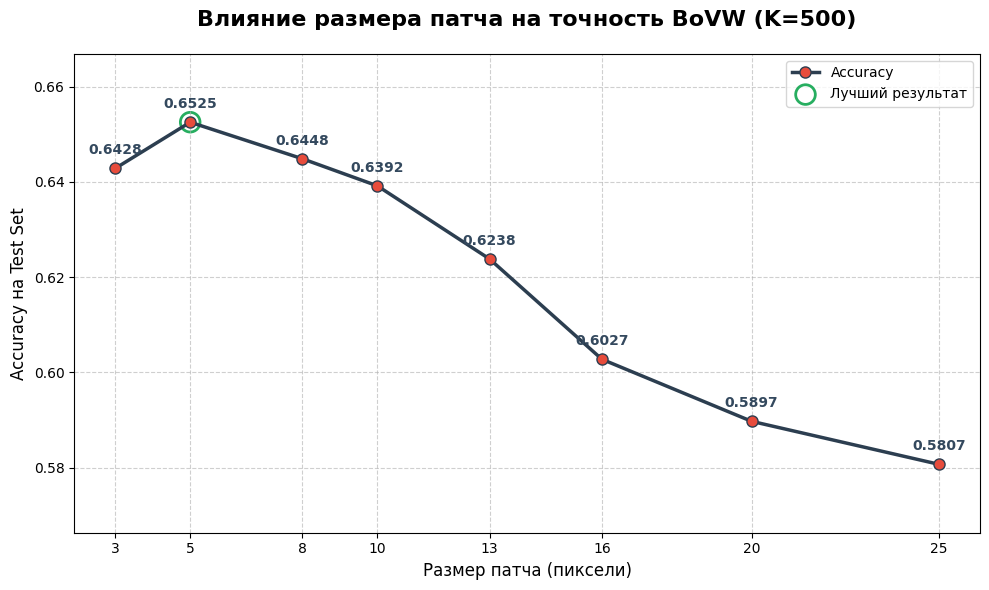

In [29]:
np.random.seed(42)

patch_sizes = [3, 5, 8, 10, 13, 16, 20, 25]
K_CLUSTERS = 500
results_accuracy = []

# Подготавливаем "сырые" данные
X_train_raw, Y_train = train_set.get_data(flatten=False)
X_test_raw, Y_test = test_set.get_data(flatten=False)

print(f"Запуск эксперимента по подбору размера патча (K={K_CLUSTERS})")
print(f"Используем {len(X_train_raw)} изображений для обучения.")

# 2. Основной цикл эксперимента
for size in patch_sizes:
    print(f"\n>>> Тестируем размер патча: {size}x{size}")
    
    # Обучаем словарь (VisualWordsEncoder)
    encoder = VisualWordsEncoder(
        train_set, 
        K=K_CLUSTERS, 
        patch_size=(size, size), 
        max_patches=80, 
        epochs=1
    )
    
    # Кодируем изображения (Трансформация в гистограммы)
    X_train_bow = transform_to_bow(encoder, X_train_raw, max_patches_per_img=250)
    X_test_bow = transform_to_bow(encoder, X_test_raw, max_patches_per_img=250)
    
    # Обучаем классификатор (SGD)
    model = SGDClassifier(
        loss='log_loss', 
        penalty='l2', 
        alpha=1e-6, 
        max_iter=1000, 
        random_state=42, 
        n_jobs=-1
    )
    model.fit(X_train_bow, Y_train)
    
    # Оцениваем результат
    y_pred = model.predict(X_test_bow)
    acc = accuracy_score(Y_test, y_pred)
    results_accuracy.append(acc)
    

# Вызов визуализатора
plot_experiment_results(
    args=patch_sizes, 
    accuracies=results_accuracy, 
    title=f"Влияние размера патча на точность BoVW (K={K_CLUSTERS})",
    x_label="Размер патча (пиксели)",
    y_label="Accuracy на Test Set"
)